# Object Detection with Faster R-CNN
- Faster R-CNN을 이용해 물체인식 시도

In [92]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## bbox 예시

In [93]:
image = torch.zeros((1,3,800,800))
image.size()

torch.Size([1, 3, 800, 800])

In [94]:
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]])
bbox

tensor([[ 20.,  30., 400., 500.],
        [300., 400., 500., 600.]])

In [95]:
np.array(bbox)

array([[ 20.,  30., 400., 500.],
       [300., 400., 500., 600.]], dtype=float32)

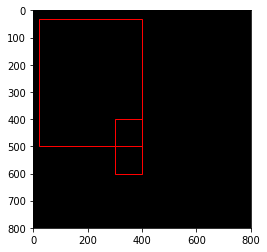

In [96]:
tensor = image
tensor = tensor.squeeze()
tensor = tensor.permute(1,2,0)
img = np.array(tensor)

fig, ax = plt.subplots()
ax.imshow(img)

import matplotlib.patches as patches
rect1 = patches.Rectangle((20,30),380,470, facecolor='none', edgecolor='r')
rect2 = patches.Rectangle((300,400),100,200, facecolor='none', edgecolor='r')

ax.add_patch(rect1)
ax.add_patch(rect2)

## Backbone -> VGG16
- inpput size == 800 
- output size == 800//16 = 50
- input과 output의 size를 위와 같도록 model 수정

In [97]:
# 확인을 위해 dummy image 생성

dummy_img = torch.zeros((1,3,800,800)).float()
dummy_img.size()

torch.Size([1, 3, 800, 800])

In [98]:
# VGG16 모델 아키텍처 보기
import torchvision

model_vgg16 = torchvision.models.vgg16(pretrained = True)

In [99]:
layer_list = list(model_vgg16.features)
layer_list

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [100]:
dummy_img.size()

torch.Size([1, 3, 800, 800])

In [101]:
layer_list[0](dummy_img).size()

torch.Size([1, 64, 800, 800])

In [102]:
# output_size가 50이 될때까지 필요한 layer 

require_layers = []
for layer in layer_list:
    dummy_img = layer(dummy_img)
    if dummy_img.size()[2] < 800//16:
        break
    require_layers.append(layer)
    output_channel = dummy_img.size()[1]
    
print(output_channel)
print(len(require_layers))

512
30


In [103]:
a = [1,2,3,4]
a

[1, 2, 3, 4]

In [104]:
import torch.nn as nn
faster_rcnn_feature_extractor = nn.Sequential(*require_layers)
faster_rcnn_feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [107]:
output_feature = faster_rcnn_feature_extractor(image)
print(output_feature.size())

torch.Size([1, 512, 50, 50])


## Generate Anchor box(방법 확인, 실제 만드는 건 뒤에)
- 각 비율, 크기마다 다른 anchor box 생성
- 각 box는 x1,y1,x2,y2를 가지고 있음 -> size == (9,4)
- 1개의 feature map에 있는 1개의 픽셀에 대해 생성
> Now every pixel in the output feature map maps to corresponding 16 * 16 pixels in the image. This is shown in the below image<br>
-> 800x800에서 50x50으로 축소했으니 원본에서 16x16사이즈의 anchor box가 결국 feature map에서의 1개의 픽셀이 된다.

In [112]:
ratio = [0.5, 1, 2]
anchor_scales = [8,16,32]

anchor_base = np.zeros((len(ratio) * len(anchor_scales), 4))
anchor_base

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [122]:
# anchor base 채우기
sub_sample = 16
ctr_x = sub_sample / 2
ctr_y = sub_sample / 2

for i in range(len(ratio)):
    for j in range(len(anchor_scales)):
        h = sub_sample * anchor_scales[j] * np.sqrt(ratio[i])
        w = sub_sample * anchor_scales[j] * np.sqrt(1/ratio[i])
        print(h,w)
        
        index = i * len(anchor_scales) + j
        print(index)
        
        anchor_base[index, 0] = ctr_y - h / 2
        anchor_base[index, 1] = ctr_x - w / 2
        anchor_base[index, 2] = ctr_y + h / 2
        anchor_base[index, 3] = ctr_x + w / 2
        
anchor_base
       

90.50966799187809 181.01933598375618
0
181.01933598375618 362.03867196751236
1
362.03867196751236 724.0773439350247
2
128.0 128.0
3
256.0 256.0
4
512.0 512.0
5
181.01933598375618 90.50966799187809
6
362.03867196751236 181.01933598375618
7
724.0773439350247 362.03867196751236
8


array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       [ -56.        ,  -56.        ,   72.        ,   72.        ],
       [-120.        , -120.        ,  136.        ,  136.        ],
       [-248.        , -248.        ,  264.        ,  264.        ],
       [ -82.50966799,  -37.254834  ,   98.50966799,   53.254834  ],
       [-173.01933598,  -82.50966799,  189.01933598,   98.50966799],
       [-354.03867197, -173.01933598,  370.03867197,  189.01933598]])

**위 작업은 1개의 feature map에 대하여 생성한 anchor box**
- image 사이즈보다 큰 anchor box는 negaitve values로 취급, 나중에 loss계산할 때 빼준다(-1로 바꿔줌)
- image가 50x50임으로 각 픽셀에 대해 anchor box 생성하면 -> 17500(50x50x9)

## feature map에 있는 모든 pixel에 대하여 anchor box 생성

### 모든 픽셀에 대한 센터값 모음 생성(ctr)

In [168]:
# 모든 픽셀에 대해 센터값(ctr_x, ctr_y) 생성

feature_size = 800//16
ctr_x = np.arange(16, (feature_size+1)*16, 16)
ctr_y = np.arange(16, (feature_size+1)*16, 16)

index = 0
ctr = np.zeros((len(ctr_x) * len(ctr_y), 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index += 1
        
ctr.shape # 1 이미지에 대한 모든 anchor box의 중심점의 모음

(2500, 2)

### 각 센터값에 대당하는 anchor box 생성(위와 다르게 실제로 생성)
- 1개의 feature map에 해당하는 모든 anchor box 생성

In [186]:
anchors = np.zeros((feature_size * feature_size * 9, 4)) # 각 anchor box에 대한 y1, x1, y2, x2

index = 0
for c in ctr: # y,x
    ctr_y, ctr_x = c
    for i in range(len(ratio)):
        for j in range(len(anchor_scales)):
            h = sub_sample * anchor_scales[j] * np.sqrt(ratio[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1/ratio[i])
            
            anchors[index, 0] = ctr_y - h/2 # y1
            anchors[index, 1] = ctr_x - w/2 # x1
            anchors[index, 2] = ctr_y + h/2 # y2
            anchors[index, 3] = ctr_x + w/2 # x2
            index += 1
print(anchors.shape)

(22500, 4)


## 모든 Anchor box에 Labels과 location 할당하기
**두 종류의 Anchor에는 'Positive label'을 할당**
1. 정답(Ground-Truth)과 비교했을 때 IOU(Intersection-over-Union)값이 가장 큰 Anchor/Anchors
2. 정답(Ground-Truth)과 비교했을 때 IOU(Intersection-over-Union)값이 **0.7** 이상일 때
> **Object가 1개만 있을 때는 여러 Anchor box에 Positive label을 할당하는 경우가 있다.**

**아래와 같은 Anchor에는 'Negative label'을 할당**
1. 정답(Ground-Truth)과 비교했을 때 IOU(Intersection-over-Union)값이 **0.3**보다 작을 때


In [188]:
bbox = np.asarray([[20, 30, 400, 500], [300, 400, 500, 600]], dtype=np.float32) # y1, x1, y2, x2
labels = np.asarray([6, 8], dtype=np.int8) # 0값은 배경을 나타냄

### 유효한(valid) Anchor box의 index 찾기
- Anchor box가 image보다 크면 유효하지 않음
- 즉, Anchor box의 x1 y1 x2 y2 값들이 모두 0~800 사이에 있어야 유효한 box

In [204]:
index_inside = np.where((anchors[:,0] >= 0) &
                        (anchors[:,1] >= 0) &
                        (anchors[:,2] <= 800) &
                        (anchors[:,3] <= 800))[0]
print(index_inside.shape)
print(anchors[index_inside[0]])

(8940,)
[ 13.49033201  10.745166   194.50966799 101.254834  ]


### Label 행렬 만들기
- 여기서 label은 물체가 있는지 없는지(objectness)만 판별
- 따라서 1또는 -1로 표시(1은 물체가 있고 -1은 background)
> **유효한 Anchor box 개수 = label 행렬 크기**

In [222]:
label = np.empty_like(index_inside)
label.fill(-1)
label.shape

(8940,)

### 유효한 Anchor box 추출

In [226]:
valid_anchor_boxes = anchors[index_inside]
valid_anchor_boxes.shape

(8940, 4)

### IOU 계산
- 위에서 임의로 정의한 bbox를 정답(Ground-Truth)이라고 가정

In [236]:
ious = np.zeros((len(valid_anchor_boxes), 2))

for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2-ya1) * (xa2-xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2-yb1) * (xb2-xb1)
        
        inter_x1 = max([xa1, xb1])
        inter_y1 = max([ya1, yb1])
        inter_x2 = min([xa2, xb2])
        inter_y2 = min([ya2, yb2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area/(box_area + anchor_area - inter_area) # inter_area가 반복됨으로 한 번 빼준다.
            
        else:
            iou = 0
            
        ious[num1, num2] = iou # 각각의 Anchor box에 대한 2 objects의 iou 값
        
ious.shape

(8940, 2)